In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

In [0]:
import os
import cv2
import numpy as np
!pip install -U keras
!pip install tensorflow-gpu==2.1.0rc0

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [0]:
# Function to convert image from greyscale to one hot (i.e. 3 channels)
def convertToOneHot(image):
    num_classes = 4
    shape = image.shape[:2]+(num_classes,)
    encoded_image = np.zeros(shape, dtype=np.uint8)
    for r in range(len(image)):
      for c in range(len(image[0])):
        if image[r][c]==0:
          encoded_image[r][c][0] = 1
        elif image[r][c]==85:
          encoded_image[r][c][1] = 1
        elif image[r][c]==170:
          encoded_image[r][c][2] = 1
        else:
          encoded_image[r][c][3] = 1
    return encoded_image

In [0]:
# Function to convert back from one hot image to greyscale
def convertFromOneHot(image):
    shape = image.shape[:2]
    encoded_image = np.zeros(shape, dtype=np.uint8)
    for r in range(len(image)):
      for c in range(len(image[0])):
        if image[r][c][0] == 1:
          encoded_image[r][c] = 0
        elif image[r][c][1] == 1:
          encoded_image[r][c] = 85
        elif image[r][c][2] == 1:
          encoded_image[r][c] = 170
        else:
          encoded_image[r][c] = 255
    return encoded_image

In [0]:
PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/4 Class ER"

Train = ['263', '232', '242', '230']
Test  = ['221', '246', '239']

# Train set patients: 230 232 239 242 
TrainX_1 = np.load(PATH + '/ER IHC 263 Images.npy')
TrainY_1 = np.load(PATH + '/ER IHC 263 Masks.npy')
TrainX_2 = np.load(PATH + '/ER IHC 232 Images.npy')
TrainY_2 = np.load(PATH + '/ER IHC 232 Masks.npy')
TrainX_3 = np.load(PATH + '/ER IHC 242 Images.npy')
TrainY_3 = np.load(PATH + '/ER IHC 242 Masks.npy')
TrainX_4 = np.load(PATH + '/ER IHC 230 Images.npy')
TrainY_4 = np.load(PATH + '/ER IHC 230 Masks.npy')

# Test set patients: 221 246 263
TestX_1 = np.load(PATH + '/ER IHC 221 Images.npy')
TestY_1 = np.load(PATH + '/ER IHC 221 Masks.npy')
TestX_2 = np.load(PATH + '/ER IHC 246 Images.npy')
TestY_2 = np.load(PATH + '/ER IHC 246 Masks.npy')
TestX_3 = np.load(PATH + '/ER IHC 239 Images.npy')
TestY_3 = np.load(PATH + '/ER IHC 239 Masks.npy')

In [0]:
TrainX = np.concatenate((TrainX_1, TrainX_2, TrainX_3, TrainX_4), axis=0)
TrainGroundTruth = np.concatenate((TrainY_1, TrainY_2, TrainY_3, TrainY_4), axis=0)
TrainY = []

for img in TrainGroundTruth:
  encoded_img = convertToOneHot(img)
  TrainY.append(encoded_img)

TrainY = np.asarray(TrainY)

TestX = np.concatenate((TestX_1, TestX_2, TestX_3), axis=0)
TestGroundTruth = np.concatenate((TestY_1, TestY_2, TestY_3), axis=0)
TestY = []

for img in TestGroundTruth:
  encoded_img = convertToOneHot(img)
  TestY.append(encoded_img)

TestY = np.asarray(TestY)

ValidX = TrainX[1800:, : ]
ValidY = TrainY[1800:, : ]

TrainX = TrainX[0:1800, : ]
TrainY = TrainY[0:1800, : ]

print(TrainX.shape)
print(TrainY.shape)
print(TestX.shape)
print(TestY.shape)
print(ValidX.shape)
print(ValidY.shape)

(1800, 240, 240, 3)
(1800, 240, 240, 4)
(1440, 240, 240, 3)
(1440, 240, 240, 4)
(120, 240, 240, 3)
(120, 240, 240, 4)


In [0]:
TrainX = np.reshape(TrainX,(-1,240, 240,3))
TrainY = np.reshape(TrainY,(-1,240, 240,4))

TrainX = TrainX.astype('float32')/255

TestX = np.reshape(TestX,(-1,240, 240,3))
TestY = np.reshape(TestY,(-1,240, 240,4))

TestX = TestX.astype('float32')/255

ValidX = np.reshape(ValidX,(-1,240, 240,3))
ValidY = np.reshape(ValidY,(-1,240, 240,4))

ValidX = ValidX.astype('float32')/255

In [0]:
print(TrainX.shape)
print(TrainY.shape)

print(TestX.shape)
print(TestY.shape)

print(ValidX.shape)
print(ValidY.shape)

(1800, 240, 240, 3)
(1800, 240, 240, 4)
(1440, 240, 240, 3)
(1440, 240, 240, 4)
(120, 240, 240, 3)
(120, 240, 240, 4)


In [0]:
!pip install medpy
from keras.layers import *
import keras
from keras.models import Sequential
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
from medpy.metric import dc, precision, recall
from keras import Model


Using TensorFlow backend.


In [0]:
def get_conv_block(input_layer,nFilters,size):
    conv1 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    bn1 = BatchNormalization()(conv1)
    conv2 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn1)
    bn2 = BatchNormalization()(conv2)
    return bn2
    
def get_model():    
    input_layer = Input(shape=(240,240,3))
    block1 = get_conv_block(input_layer,32,3)
    mp1 = MaxPooling2D(pool_size=(2, 2))(block1)
    dr1 = Dropout(0.1)(mp1)
    
    block2 = get_conv_block(dr1,64,3)
    mp2 = MaxPooling2D(pool_size=(2, 2))(block2)
    dr2 = Dropout(0.1)(mp2)
    
    block3 = get_conv_block(dr2,128,3)
    mp3 = MaxPooling2D(pool_size=(2, 2))(block3)
    dr3 = Dropout(0.1)(mp3)
    
    block4 = get_conv_block(dr3,256,3)
    mp4 = MaxPooling2D(pool_size=(2, 2))(block4)
    dr4 = Dropout(0.1)(mp4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(dr4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up1 = Conv2DTranspose(256,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(conv5)
    cat1 = concatenate([block4,up1])
    dr1 = Dropout(0.1)(cat1)
    block5 = get_conv_block(dr1,256,3)

    up2 = Conv2DTranspose(128,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block5)
    cat2 = concatenate([block3,up2])
    dr2 = Dropout(0.1)(cat2)
    block6 = get_conv_block(dr2,128,3)
    
    up3 = Conv2DTranspose(64,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block6)
    cat3 = concatenate([block2,up3])
    dr3 = Dropout(0.1)(cat3)
    block7 = get_conv_block(dr3,64,3)
    
    up4 = Conv2DTranspose(32,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block7)
    cat4 = concatenate([block1,up4])
    dr4 = Dropout(0.1)(cat4)
    block8 = get_conv_block(dr4,64,3)

    conv10 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(block8)
    conv11 = Conv2D(4,(1,1), activation='softmax', padding = 'same')(conv10)

    model = Model(input_layer,conv11)
    return model

In [0]:
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 240, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 32) 9248        batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

In [0]:
import math
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
mc = ModelCheckpoint('Checkpoint.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [0]:
optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.001, decay=0.0, amsgrad=True)

In [0]:
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def combined_loss(y_true, y_pred):
  return (1*K.categorical_crossentropy(y_true, y_pred))+(1*tversky_loss(y_true, y_pred))

In [0]:
import random
batch_size = 16
def get_batch(batch_size, X_train, Y_train): 
    size_batch = batch_size
    last_index = len(X_train) - 1
    x_train = X_train
    y_train = Y_train 
    while True:
        batch_data = [[],[]]
        for i in range(0, size_batch):
            random_index = random.randint(0, last_index)
            batch_data[0].append(x_train[random_index])
            batch_data[1].append(y_train[random_index])

        yield (np.array(batch_data[0]), np.array(batch_data[1]))     
        
datagen = get_batch(batch_size, TrainX, TrainY)

        

In [0]:
from keras import backend as K      
model.compile(loss=combined_loss, optimizer= optimizer , metrics=[dice_coef,'accuracy'])

In [0]:
from math import ceil
num_epoch = 100
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models/4 Class/ER"
n_points = len(TrainX)
history = model.fit(datagen, 
                validation_data = (ValidX, ValidY),
                epochs=num_epoch,steps_per_epoch = ceil(n_points / batch_size), callbacks =[es,mc],  shuffle =True)
model.save(MODELS_PATH + '/4 Class_UNET_ER_12_04_2020.h5')

Epoch 1/100
113/113 [==============================] - 56s 496ms/step - loss: 2.7006 - dice_coef: 0.7976 - accuracy: 0.8919 - val_loss: 3.1188 - val_dice_coef: 0.9847 - val_accuracy: 0.9885

Epoch 00001: val_loss improved from inf to 3.11878, saving model to Checkpoint.h5
Epoch 2/100
113/113 [==============================] - 43s 384ms/step - loss: 2.2506 - dice_coef: 0.8996 - accuracy: 0.9180 - val_loss: 3.1044 - val_dice_coef: 0.9865 - val_accuracy: 0.9885

Epoch 00002: val_loss improved from 3.11878 to 3.10439, saving model to Checkpoint.h5
Epoch 3/100
113/113 [==============================] - 43s 384ms/step - loss: 2.1559 - dice_coef: 0.9067 - accuracy: 0.9252 - val_loss: 3.0042 - val_dice_coef: 0.9837 - val_accuracy: 0.9884

Epoch 00003: val_loss improved from 3.10439 to 3.00419, saving model to Checkpoint.h5
Epoch 4/100
113/113 [==============================] - 43s 384ms/step - loss: 2.1023 - dice_coef: 0.9130 - accuracy: 0.9281 - val_loss: 3.0844 - val_dice_coef: 0.9888 - val_

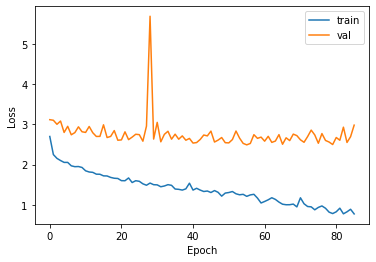

In [0]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
xc=range(len(train_loss))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

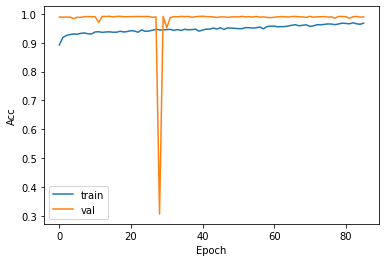

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [0]:
# MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models/4 Class/ER"
# model = keras.models.load_model(MODELS_PATH+'/4 Class_UNET_ER_12_04_2020.h5',custom_objects={ 'combined_loss': combined_loss, 'dice_coef': dice_coef })

In [0]:
# Function to find the most probable class of an image pixel by pixel
def ClassFinder(img):
  result = np.zeros(img.shape, dtype=np.uint8)
  for r in range(len(img)):
    for c in range(len(img[0])):
      idx = np.argmax(img[r][c])
      result[r][c][idx]=1
      
  return result    

In [0]:
TrainX = np.concatenate((TrainX,ValidX))
TrainY = np.concatenate((TrainY,ValidY))
train_result = model.predict(TrainX, batch_size=16)
print(np.shape(train_result))
Train_predict = [ ]
for img in train_result:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Train_predict.append(encoded_img)

Predicted_images = np.asarray(Train_predict)
print(Predicted_images.shape)
np.unique(Predicted_images)
# dice = dc(train_result, TrainY)
# pre  = precision(train_result,TrainY)
# re   = recall(train_result,TrainY)
# print('Train dc: '  + str(dice))
# print('Train pre: ' + str(pre))
# print('Train re: '  + str(re))

(1920, 240, 240, 4)
(1920, 240, 240)


array([  0,  85, 170, 255], dtype=uint8)

In [0]:
test_result = model.predict(TestX, batch_size=16)
print(np.shape(test_result))

Test_predict = [ ]
for img in test_result:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Test_predict.append(encoded_img)

Predicted_images_test = np.asarray(Test_predict)
print(Predicted_images_test.shape)
np.unique(Predicted_images_test)
# dice = dc(test_result, TestY)
# pre  = precision(test_result,TestY)
# re   = recall(test_result,TestY)
# print('Test dc: '  + str(dice))
# print('Test pre: ' + str(pre))
# print('Test re: '  + str(re))

(1440, 240, 240, 4)
(1440, 240, 240)


array([  0,  85, 170, 255], dtype=uint8)

In [0]:
from sklearn.metrics import confusion_matrix
def get_confusion_matrix(Actual, Predicted):
  ActualY = np.reshape(Actual,(-1, Actual.shape[3]))
  PredY = np.reshape(Predicted,(-1, Predicted.shape[3]))
  matrix = confusion_matrix(ActualY.argmax(axis = 1), PredY.argmax(axis = 1))
  return matrix

def get_precision(confusion_matrix):
  precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 0)
  nan_indices = np.isnan(precision)
  precision[nan_indices] = 0
  return precision

def get_recall(confusion_matrix):
  recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)
  nan_indices = np.isnan(recall)
  recall[nan_indices] = 0
  return recall


In [0]:
test_matrix = get_confusion_matrix(TestY, test_result)
train_matrix = get_confusion_matrix(TrainY, train_result)
print(test_matrix)
print(train_matrix)
# TestY.shape[3]
# test_result.shape

[[74380126   143654   389878   875987]
 [  222993   162067   218728    72481]
 [  511044    48378   842247   607812]
 [  649345     6021   184656  3628583]]
[[95484109   101910   416943   570957]
 [  624775   749157    55920    10157]
 [  624886    10101  4284795   118160]
 [  640926     1228   141394  6756582]]


In [0]:
test_precision = get_precision(test_matrix)
print('Test Precision')
print(test_precision)
test_recall = get_recall(test_matrix)
print('Test Recall')
print(test_recall)
train_precision = get_precision(train_matrix)
print('Train Precision')
print(train_precision)
train_recall = get_recall(train_matrix)
print('Train Recall')
print(train_recall)

Test Precision
[0.98174079 0.4500361  0.51497546 0.69984164]
Test Recall
[0.98140222 0.23964872 0.41913658 0.81201695]
Train Precision
[0.98058441 0.86869257 0.87461717 0.90621144]
Train Recall
[0.98871528 0.52024467 0.85050503 0.89608296]


In [0]:
weight_matrix = np.zeros((4,1))
weight_matrix[0] = 1/4
weight_matrix[1] = 1/4
weight_matrix[2] = 1/4
weight_matrix[3] = 1/4
print(weight_matrix.shape)

(4, 1)


In [0]:
def get_overall_precision(precision, weights):
  final_precision = np.dot(precision,weights)
  return final_precision

def get_overall_recall(recall, weights):
  final_recall = np.dot(recall ,weights)
  return final_recall

In [0]:
final_test_precision  = get_overall_precision(test_precision, weight_matrix)
final_test_recall     = get_overall_recall(test_recall, weight_matrix)
final_train_precision = get_overall_precision(train_precision, weight_matrix)
final_train_recall    = get_overall_recall(train_recall, weight_matrix)
print('Final Test Precision')
print(final_test_precision)
print('Final Test Recall')
print(final_test_recall)
print('Final Train Precision')
print(final_train_precision)
print('Final Train Recall')
print(final_train_recall)

Final Test Precision
[0.88219799]
Final Test Recall
[0.81740149]
Final Train Precision
[1.2100352]
Final Train Recall
[1.08518264]


In [0]:
from scipy.stats import hmean

def dice_coefficient(precision, recall):
  return hmean(np.asarray([precision , recall]))
  

In [0]:
test_dice_coeff = dice_coefficient(final_test_precision, final_test_recall)
print('Test Dice coeff')
print(test_dice_coeff)

train_dice_coeff = dice_coefficient(final_train_precision, final_train_recall)
print('Train Dice coeff')
print(train_dice_coeff)

In [0]:
copy1  = np.copy(TestX [250])
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
copy3 = np.reshape(copy2,(240, 240,3))
Img = cv2.cvtColor(copy3,cv2.COLOR_BGR2RGB)

Mask = TestGroundTruth[250]

Predicted_Mask = Predicted_images_test[250] 

plt.subplot(131).imshow(Img)
plt.subplot(132).imshow(Mask,'gray')
plt.subplot(133).imshow(Predicted_Mask,'gray')

In [0]:
def stitchMaskPatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240] = pieces[k]
      k = k + 1
  return reconstructed_img


def stitchImagePatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920,3])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240,:] = pieces[k]
      k = k + 1
  return reconstructed_img


In [0]:
def saveNumpyOutput(mask, Patient_array):
  num = mask.shape[0]/480
  for id in range(int(num)):
    temp = []
    for i in range(id*10, id*10+10):
      print(i)
      idx = i * 48
      final_output = mask[idx:idx+48]
      final_output = stitchMaskPatches(final_output)
      temp.append(final_output)
    final_output = np.asarray(temp)
    np.save("/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/Predicted Output/ER/UNET/4 Class/12-04-2020/" + Patient_array[id], final_output)

In [0]:

# saving predicted outputs as numpy arrays for test images
saveNumpyOutput(Predicted_images, Train)
saveNumpyOutput(Predicted_images_test, Test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [0]:
!ls "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/Predicted Output/ER/UNET/4 Class/12-04-2020/"

221.npy  230.npy  232.npy  239.npy  242.npy  246.npy  263.npy


(48, 240, 240, 4)
(48, 240, 240)
(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[  0.  85. 170. 255.]


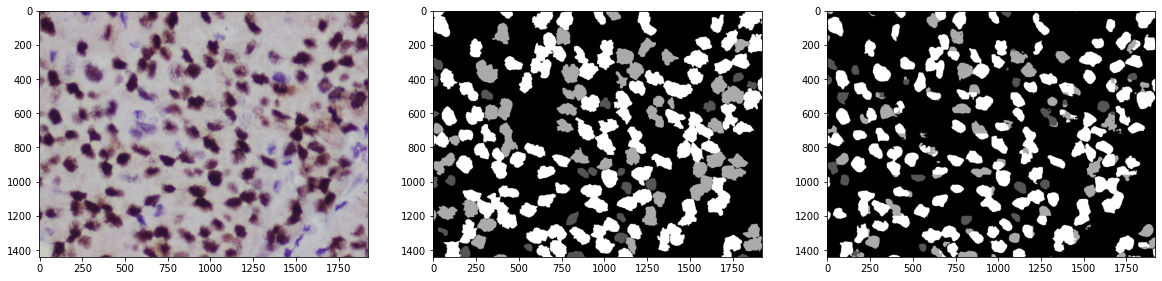

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 26   # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TestX[id:id+48]

Mask_input = TestY[id:id+48]
Test_Actual = [ ]
for img in Mask_input:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Test_Actual.append(encoded_img)
  
print(Mask_input.shape)
Mask_input = np.asarray(Test_Actual)
print(Mask_input.shape)

final_output = Predicted_images_test[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')



(48, 240, 240, 4)
(48, 240, 240)
(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[  0.  85. 170. 255.]


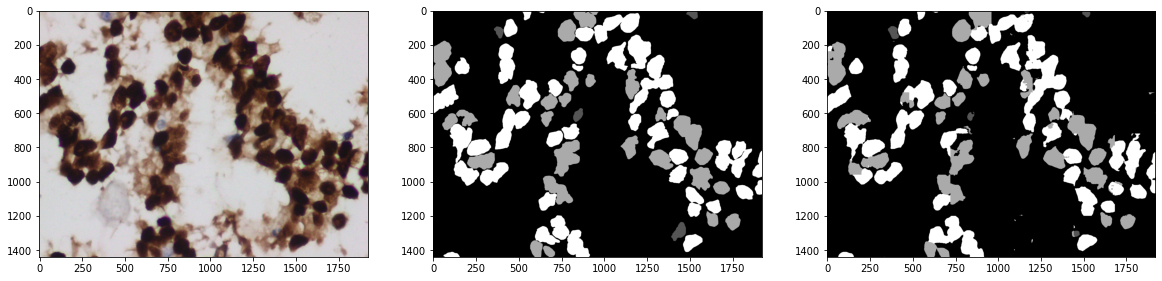

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 2  # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TrainX[id:id+48]

Mask_input = TrainY[id:id+48]
Train_Actual = [ ]
for img in Mask_input:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Train_Actual.append(encoded_img)
  
print(Mask_input.shape)
Mask_input = np.asarray(Train_Actual)
print(Mask_input.shape)

final_output = Predicted_images[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')

In [0]:
SAVE_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Predicted Images/ER/UNET/4 Class/12-04-2020"
def saveImageOutput(patients, GroundTruth, Predicted, folder):
  totalimages = patients * 10
  for id in range(totalimages):
    index = id * 48
    Mask_input = GroundTruth[index:index+48]
    GroundTruth_Actual = [ ]
    for img in Mask_input:
      img = ClassFinder(img)
      encoded_img = convertFromOneHot(img)
      GroundTruth_Actual.append(encoded_img)
    Mask_input = np.asarray(GroundTruth_Actual)
    final_output = Predicted[index:index+48]
    Mask_input   = stitchMaskPatches(Mask_input)
    final_output = stitchMaskPatches(final_output)
    cv2.imwrite(SAVE_PATH + '/Ground Truth' + folder + '/Image '+ str(id) + '.png', Mask_input)
    cv2.imwrite(SAVE_PATH +  '/Predicted Mask'+ folder + '/Image '+ str(id) + '.png', final_output)
    



In [0]:
saveImageOutput(3, TestY, Predicted_images_test, '/Test' )
saveImageOutput(4, TrainY, Predicted_images, '/Train' )